# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Требуется обучить модель классифицировать комментарии на позитивные и негативные и достичь значения метрики качества *F1* не меньше 0.75. В распоряжении набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузка и предобработка данных

Импортируем нужные библиотеки и загрузим данные

In [41]:
pip install pywsd

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

import re
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer # модуль для лемматизации
from pywsd.utils import lemmatize_sentence
from tqdm import tqdm

# TF-IDF для корпуса текстов
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, \
                                    StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, \
                            precision_score, f1_score, confusion_matrix, \
                            roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [44]:
df = df.sample(30000, random_state=42)

Выведем общую информацию о данных

In [45]:
def data_describe(data):
    print('Общая информация:')
    data.info()
    print('Первые 5 строк:')
    display(data.head())
    print('Описание датафрейма:')
    display(data.describe())
    print('Пропуски:')
    display(data.isna().sum().sort_values(ascending=False))
    print('Дубликаты:')
    display(data.duplicated().sum())
    print('Уникальные значения:')
    display(data.nunique().sort_values())
    print('Разделим признаки на категориальные и числовые:')
    num_columns = []
    cat_columns = []
    for num, i in enumerate(data.columns):
        if pd.api.types.is_numeric_dtype(data[i]):
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(data[i]):
            cat_columns.append(i)
    print('Всего числовых признаков:', len(num_columns))
    print('Всего категориальных признаков:', len(cat_columns))


data_describe(df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 31015 to 89382
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   text        30000 non-null  object
 2   toxic       30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 937.5+ KB
Первые 5 строк:


,Unnamed: 0,text,toxic
31015,31055,"Sometime back, I just happened to log on to ww...",0
102832,102929,"""\n\nThe latest edit is much better, don't mak...",0
67317,67385,""" October 2007 (UTC)\n\nI would think you'd be...",0
81091,81167,Thanks for the tip on the currency translation...,0
90091,90182,I would argue that if content on the Con in co...,0


Описание датафрейма:


,Unnamed: 0,toxic
count,30000.000000,30000.000000
mean,80129.690067,0.100533
std,45798.483390,0.300715
min,0.000000,0.000000
25%,40708.000000,0.000000
50%,79857.500000,0.000000
75%,119857.250000,0.000000
max,159449.000000,1.000000


Пропуски:


Unnamed: 0    0
text          0
toxic         0
dtype: int64

Дубликаты:


0

Уникальные значения:


toxic             2
Unnamed: 0    30000
text          30000
dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 2
Всего категориальных признаков: 1


- видим, что набор данных содержит 159292 записей и 3 признака:
      - признак `Unnamed: 0`, дублирующий индекс, не несущий никакой информации, требующий удаления
      - категориальный признак `text` с текстом комментария
      - таргет `toxic` - числовой бинарный признак: является ли комментарий токсичным (0/1)
- пропуски и дубликаты отсутствуют

In [46]:
df['text'].duplicated().sum()

0

Уберём из набора данных столбец `Unnamed: 0`

In [47]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Проверим дисбаланс классов

In [48]:
df['toxic'].value_counts()

0    26984
1     3016
Name: toxic, dtype: int64

In [49]:
print('Доля негативных комментариев:', round(len(df[df['toxic']==1])/len(df) * 100, 1), '%')

Доля негативных комментариев: 10.1 %


Потребуется перебалансировка классов. Метод перебалансировки выберем позднее.

Не лишним будет проверить данные на корректную разметку. Возьмем 20 случайных объектов, размеченных как негативные:

In [50]:
df.sample(20, weights='toxic', random_state=RANDOM_STATE)

,text,toxic
158409,I am going to shove a burning torch up your as...,1
87556,sex toy \n\nWhy are you bulling up my edits? S...,1
45747,Get amped on demamp cornhuskers f**king rule t...,1
130449,"""\n\n Congratulations \n\nWell I suppose I hav...",1
113273,"i know your racist,just admit it!",1
2152,"""\n\nI agree to that. many parts of the articl...",1
145049,OsFan \n\ni still think you're a piece of sh!t.,1
140276,good luck with your struggle in wikipedia by f...,1
104331,Suck it bitch!!!!!!! \n\nha ha bitch fuck!!!!!,1
13136,"NATE, YOU ARE FUCKING GOD DAMN FIRED! YOU ARE ...",1


Негатив на самом деле есть, разметка корректная

**Выводы:**

- исходный датафрейм содержит 159292 записей и 3 признака:
      - признак `Unnamed: 0`, дублирующий индекс, не несущий никакой информации
      - категориальный признак `text` с текстом комментария
      - таргет `toxic` - числовой бинарный признак: является ли комментарий токсичным (0/1)
- пропуски и дубликаты отсутствуют
- есть дисбаланс классов (0/1: 90%/10%)
- текст размечен верно

## Анализ данных

Прежде чем извлечь признаки из текста, упростим его.

Использовать будем следующие этапы предобработки текста:

- токенизация - разбиение текста на токены: отдельные фразы, слова, символы.

- лемматизация - процесс приведения слова к его базовой форме (лемме), которая может быть использована для поиска или сравнения слов ("running", "ran", "runs" - "run")

Для лемматизации английского текста используем библиотеку NLTK

Вначале очистим тексты от лишних символов с помощью регулярных выражений:

In [51]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear_text = " ".join(clear_text.split())
    return clear_text

In [52]:
df['text_clear'] = df['text'].apply(clear_text)

Оптимизируем лемматизацию текста с помощью lemmatize_sentence:

In [32]:
tqdm.pandas()
df['text_lemm_clear'] = df['text_clear'].apply(lemmatize_sentence)

In [33]:
def join_text(text):
    return ' '.join(text)

In [34]:
df['text_lemm_clear'] = df['text_lemm_clear'].apply(join_text)

In [35]:
df.head()

,text,toxic,text_clear,text_lemm_clear
31015,"Sometime back, I just happened to log on to ww...",0,Sometime back I just happened to log on to www...,sometime back i just happen to log on to www i...
102832,"""\n\nThe latest edit is much better, don't mak...",0,The latest edit is much better don t make this...,the late edit be much good don t make this art...
67317,""" October 2007 (UTC)\n\nI would think you'd be...",0,October UTC I would think you d be able to get...,october utc i would think you d be able to get...
81091,Thanks for the tip on the currency translation...,0,Thanks for the tip on the currency translation...,thanks for the tip on the currency translation...
90091,I would argue that if content on the Con in co...,0,I would argue that if content on the Con in co...,i would argue that if content on the con in co...


Отфильтруем тексты - исключим стоп-слова с помощью модуля NLTK - stopwords:

In [36]:
stop_words = set(stopwords.words('english'))

def stopwords_text(text):
    filtered_text = [word for word in text.split() if word.lower() not in stop_words]
    return " ".join(filtered_text)

# применим функцию к столбцу датафрейма с текстом
df['text_lemm_clear_stopwords'] = df['text_lemm_clear'].apply(stopwords_text)

In [37]:
df = df.drop(['text', 'text_clear', 'text_lemm_clear'], axis=1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 31015 to 89382
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   toxic                      30000 non-null  int64 
 1   text_lemm_clear_stopwords  30000 non-null  object
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


In [39]:
df.head()

,toxic,text_lemm_clear_stopwords
31015,0,sometime back happen log www izoom friend refe...
102832,0,late edit much good make article state super
67317,0,october utc would think able get point across ...
81091,0,thanks tip currency translation think
90091,0,would argue content con comparison art music p...


**Разделение данных на выборки**

Зададим параметр `stratify`, чтобы учесть баланс классов при разбиении

In [40]:
features = df['text_lemm_clear_stopwords']
target = df['toxic']

# создадим обучающую выборку и валидационную выборки
features_train, features_valid, \
target_train, target_valid = train_test_split(features,
                                              target,
                                              test_size=0.2,
                                              random_state=RANDOM_STATE,
                                              stratify=target)
# разделим валидационную пополам - получим тестовую выборку
features_valid, features_test, \
target_valid, target_test = train_test_split(features_valid,
                                             target_valid,
                                             test_size=0.50,
                                             random_state=RANDOM_STATE,
                                             stratify=target_valid)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_valid) / len(df))
print(len(features_test) / len(df))

(24000,)
(3000,)
(3000,)
0.8
0.1
0.1


**Выводы:**
- текст упрощен и подготовлен к обучению, выполнены:
  - токенизация - разбиение текста на токены: отдельные фразы, слова, символы
  - лемматизация - приведение слова к начальной форме - лемме ('looks' - 'look')
  - исключены лишние символы и стоп-слова
- данные поделены на тренировочную, валидационную и тестовую выборки в соотношении 80%:10%:10%

## Обучение

Перед нами стоит задача классификации тональности текста. Анализ тональности текста, или сентимент-анализ, выявляет эмоционально окрашенные слова. Оценить тональность - значит отметить текст как позитивный или негативный. Признаки - это слова из корпуса и их величины TF-IDF для каждого текста.

Для определения тональности применим величины TF-IDF как признаки.

Обучать в нашем проекте будем следующие модели:

- LogisticRegression
- RandomForestClassifier
- GradientBoostingClassifier

**LogisticRegression**

Чтобы модель показывала стабильно хорошие результаты нужно её обучить на наборе данных, где равное количество положительных и отрицательных комментариев. Для избавления от дисбаланса классов и улучшения показателей качества предсказаний при обучении моделей используем автобалансировку

In [53]:
# Создание pipeline с использованием TfidfVectorizer()
# и модели логистической регрессии
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(solver='liblinear',
                                 class_weight='balanced'))
])

# Определение параметров для поиска лучшей модели
# логистической регрессии с помощью GridSearchCV
parameters = {
    'model__C': [5, 10],
    'model__penalty': ['l1', 'l2'],
    'model__tol': [1e-5, 1e-6]
}

# Обучение модели на трейне с помощью GridSearchCV
lr_model_gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
lr_model_gs.fit(features_train, target_train)

# Предсказание меток классов на тестовых данных
lr_valid_preds = lr_model_gs.predict(features_valid)

lr_best_params = lr_model_gs.best_params_
print(lr_best_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'model__C': 10, 'model__penalty': 'l2', 'model__tol': 1e-05}


In [54]:
accuracy_valid_lr = accuracy_score(lr_valid_preds, target_valid)
precision_valid_lr = precision_score(target_valid, lr_valid_preds)
recall_valid_lr = recall_score(target_valid, lr_valid_preds)
f1_score_lr = f1_score(target_valid, lr_valid_preds)

print('Accuracy score:', accuracy_valid_lr)
print('Precision score:', precision_valid_lr)
print('Recall score:', recall_valid_lr)
print('F1 score:', f1_score_lr)

Accuracy score: 0.9466666666666667
Precision score: 0.7366666666666667
Recall score: 0.7317880794701986
F1 score: 0.7342192691029901


In [55]:
probabilities_valid = lr_model_gs.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC логистической регрессии:', auc_roc_lr)

AUC-ROC логистической регрессии: 0.9505790406433021


Визуализируем матрицу ошибок

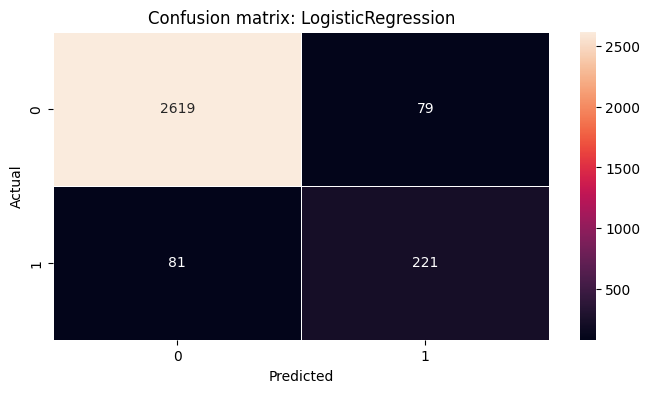

In [56]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, lr_valid_preds),
            annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

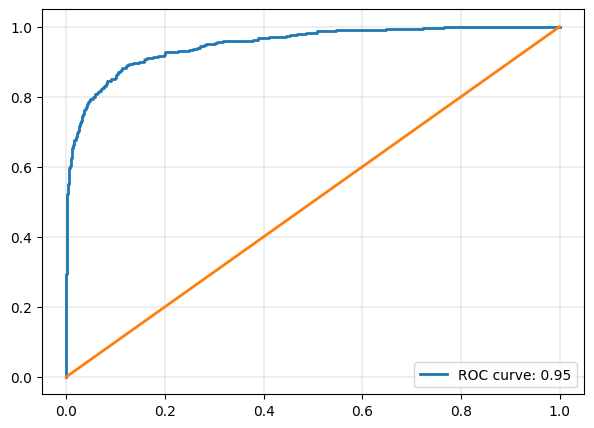

In [57]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {auc_roc_lr:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

**RandomForestClassifier**

In [58]:
# Создание pipeline с использованием TfidfVectorizer()
# и модели RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

# Определение параметров для поиска лучшей модели
# логистической регрессии с помощью GridSearchCV
parameters = {'model__n_estimators': [100, 150]}

# Обучение модели на трейне с помощью GridSearchCV
rfc_model_gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
rfc_model_gs.fit(features_train, target_train)

# Предсказание меток классов на тестовых данных
rfc_valid_preds = rfc_model_gs.predict(features_valid)

rfc_best_params = rfc_model_gs.best_params_
print(rfc_best_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'model__n_estimators': 100}


In [59]:
accuracy_valid_rfc = accuracy_score(rfc_valid_preds, target_valid)
precision_valid_rfc = precision_score(target_valid, rfc_valid_preds)
recall_valid_rfc = recall_score(target_valid, rfc_valid_preds)
f1_score_rfc = f1_score(target_valid, rfc_valid_preds)

print('Accuracy score:', accuracy_valid_rfc)
print('Precision score:', precision_valid_rfc)
print('Recall score:', recall_valid_rfc)
print('F1 score:', f1_score_rfc)

Accuracy score: 0.9393333333333334
Precision score: 0.9615384615384616
Recall score: 0.4139072847682119
F1 score: 0.5787037037037038


In [60]:
probabilities_valid = rfc_model_gs.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier:', auc_roc_rfc)

AUC-ROC RandomForestClassifier: 0.9411662551117089


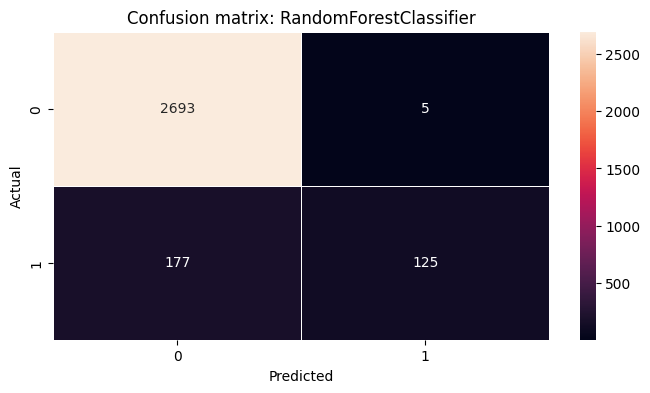

In [61]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, rfc_valid_preds),
            annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

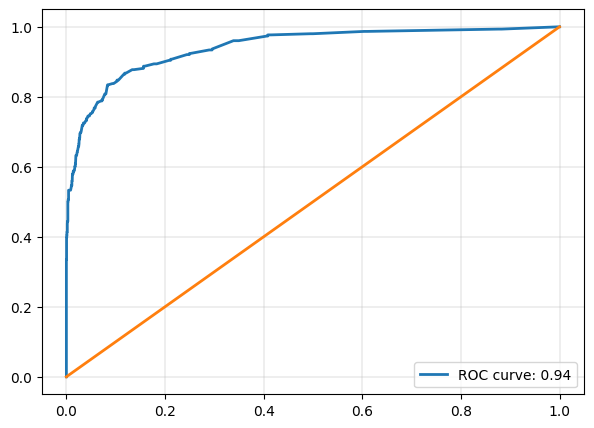

In [62]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {auc_roc_rfc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

**GradientBoostingClassifier**

In [63]:
# Создание pipeline с использованием TfidfVectorizer()
# и модели GradientBoostingClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', GradientBoostingClassifier())
])

# Определение параметров для поиска лучшей модели
# логистической регрессии с помощью GridSearchCV
parameters = {'model__learning_rate': [0.2, 0.3]}

# Обучение модели на трейне с помощью GridSearchCV
gbc_model_gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
gbc_model_gs.fit(features_train, target_train)

# Предсказание меток классов на тестовых данных
gbc_valid_preds = gbc_model_gs.predict(features_valid)

gbc_best_params = gbc_model_gs.best_params_
print(gbc_best_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'model__learning_rate': 0.3}


In [64]:
accuracy_valid_gbc = accuracy_score(gbc_valid_preds, target_valid)
precision_valid_gbc = precision_score(target_valid, gbc_valid_preds)
recall_valid_gbc = recall_score(target_valid, gbc_valid_preds)
f1_score_gbc = f1_score(target_valid, gbc_valid_preds)

print('Accuracy score:', accuracy_valid_gbc)
print('Precision score:', precision_valid_gbc)
print('Recall score:', recall_valid_gbc)
print('F1 score:', f1_score_gbc)

Accuracy score: 0.95
Precision score: 0.8689320388349514
Recall score: 0.5927152317880795
F1 score: 0.704724409448819


In [65]:
probabilities_valid = gbc_model_gs.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_gbc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC GradientBoostingClassifier:', auc_roc_gbc)

AUC-ROC GradientBoostingClassifier: 0.9171620871972863


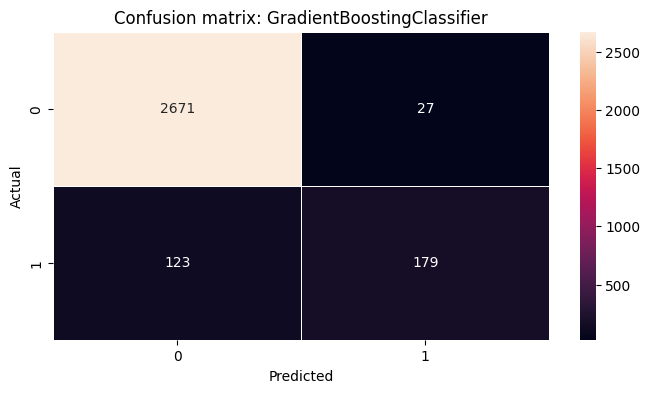

In [66]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, gbc_valid_preds),
            annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: GradientBoostingClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

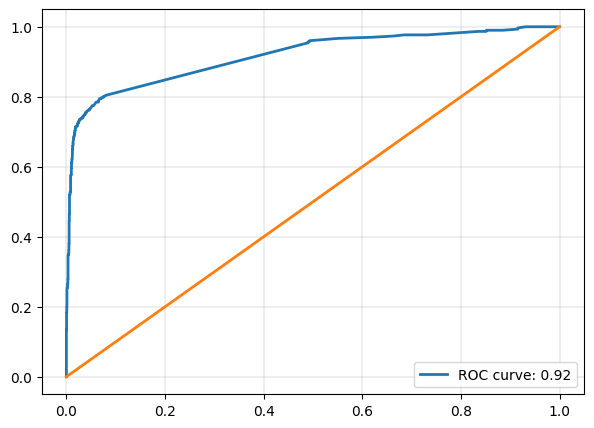

In [67]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {auc_roc_gbc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

Соберем результаты наших моделей в таблицу:

In [68]:
data = [{'Accuracy': accuracy_valid_lr, 'Recall': recall_valid_lr,
         'Precision': precision_valid_lr, 'F1': f1_score_lr,
         'AUC-ROC': auc_roc_lr},
        {'Accuracy': accuracy_valid_rfc, 'Recall': recall_valid_rfc,
         'Precision': precision_valid_rfc,
         'F1': f1_score_rfc, 'AUC-ROC': auc_roc_rfc},
        {'Accuracy': accuracy_valid_gbc, 'Recall': recall_valid_gbc,
         'Precision': precision_valid_gbc,
         'F1': f1_score_gbc, 'AUC-ROC': auc_roc_gbc}]

model_result = pd.DataFrame(data, index=['LogisticRegression',
                                         'RandomForestClassifier',
                                         'GradientBoostingClassifier'])
model_result

,Accuracy,Recall,Precision,F1,AUC-ROC
LogisticRegression,0.946667,0.731788,0.736667,0.734219,0.950579
RandomForestClassifier,0.939333,0.413907,0.961538,0.578704,0.941166
GradientBoostingClassifier,0.950000,0.592715,0.868932,0.704724,0.917162


**Выводы:**

Абсолютным лидером и по метрике F1, и по значению AUC-ROC является модель логистической регрессии. На ней и будем проводить тестирование с подобранными гиперпараметрами

In [69]:
lr_best_params

{'model__C': 10, 'model__penalty': 'l2', 'model__tol': 1e-05}

**Итого:**
- выбираем модель LogisticRegression(random_state=RANDOM_STATE, C=10, class_weight='balanced', solver='liblinear', penalty = 'l1', tol': 1e-06)
- итого, значения метрик LogisticRegression на валидационной выборке после подбора гиперпараметров:
  - F1-score: 0.734
  - AUC-ROC: 0.95

**Тестирование модели**

Для повышения качества модели объединим валидационную и тренировочную выборки

In [70]:
features_train_final = pd.concat([features_train, features_valid],
                                 axis=0, ignore_index=True)
target_train_final = pd.concat([target_train, target_valid],
                               axis=0, ignore_index=True)

Протестируем модель на объединенной выборке

In [71]:
# Создание pipeline с использованием TfidfVectorizer()
# и модели логистической регрессии
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=150,
                                 solver='liblinear',
                                 class_weight='balanced'))
])

# Определение параметров для поиска лучшей модели
# логистической регрессии с помощью GridSearchCV
parameters = {
    'model__C': [10],
    'model__penalty': ['l1'],
    'model__tol': [1e-06]
}

# Обучение модели на объединенном трейне и валидации с помощью GridSearchCV
lr_model_gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
lr_model_gs.fit(features_train_final, target_train_final)

# Предсказание меток классов на тестовых данных
lr_test_preds = lr_model_gs.predict(features_test)

lr_best_params = lr_model_gs.best_params_
print(lr_best_params)

# Оценка качества модели на тестовых данных
accuracy_test_lr = accuracy_score(lr_test_preds, target_test)
precision_test_lr = precision_score(target_test, lr_test_preds)
recall_test_lr = recall_score(target_test, lr_test_preds)
f1_score_lr = f1_score(target_test, lr_test_preds)

print('Accuracy score:', accuracy_test_lr)
print('Precision score:', precision_test_lr)
print('Recall score:', recall_test_lr)
print('F1 score:', f1_score_lr)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'model__C': 10, 'model__penalty': 'l1', 'model__tol': 1e-06}
Accuracy score: 0.9463333333333334
Precision score: 0.7287581699346405
Recall score: 0.7408637873754153
F1 score: 0.7347611202635914


In [72]:
probabilities_valid = lr_model_gs.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC логистической регрессии:', auc_roc_lr)

AUC-ROC логистической регрессии: 0.9593463310516138


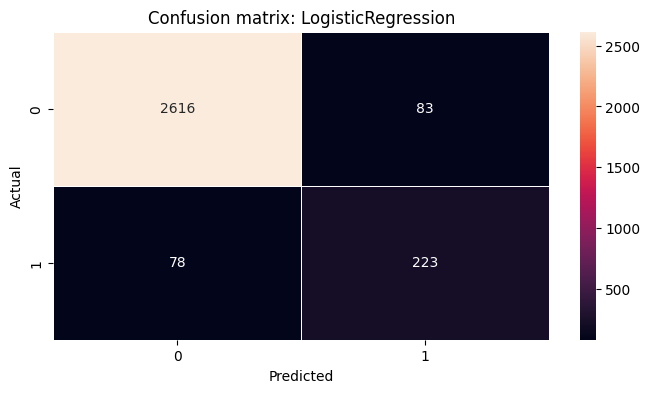

In [73]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_test, lr_test_preds),
            annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

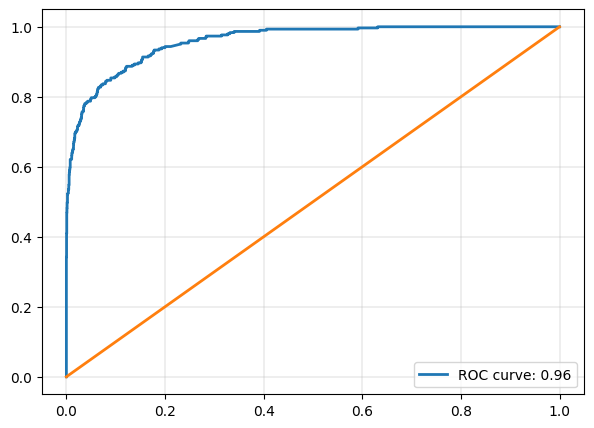

In [74]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {auc_roc_lr:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

Значение AUC-ROC довольно высокое, что говорит о неплохом качестве модели.

Сама форма ROC-кривой также свидетельствует о том, что модель хорошо справляется с предсказаниями на новых данных

Удалось достигнуть значения F1-меры для тестовой выборки необходимого по условию задания уровня: 0.76. Модель можно использовать.

**Проверка на адекватность**

Построим dummy-модель в качестве простого базиса, с которым сравним результаты лучшей модели на тестовой выборке

In [75]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', DummyClassifier(strategy='stratified'))
])

# Определение параметров для поиска лучшей модели
# логистической регрессии с помощью GridSearchCV
parameters = {'model__strategy': ['stratified']}

# Обучение модели на объединенном трейне и валидации с помощью GridSearchCV
dummy_model_gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
dummy_model_gs.fit(features_train_final, target_train_final)

# Предсказание меток классов на тестовых данных
dummy_test_preds = dummy_model_gs.predict(features_test)

# Оценка качества модели на тестовых данных
f1_score_dummy = f1_score(target_test, dummy_test_preds)
print('F1-score константной модели на тестовой выборке:', round(f1_score_dummy))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
F1-score константной модели на тестовой выборке: 0


In [76]:
def test_models(dummy_predictions, model_predictions):
    if dummy_predictions < model_predictions:
        print('Модель прошла проверку на адекватность')
    else:
        print('Модель не прошла проверку на адекватность')

In [78]:
test_models(f1_score_dummy, f1_score_lr)

Модель прошла проверку на адекватность


Итого, на тестовой выборке была проверена выбранная модель логистической регрессии:
- F1-score: 0.76
- AUC-ROC: 0.94

Модель прошла проверку на адекватность

## Выводы

Для нового сервиса компании "Викишоп" требовалось разработать модель классификации комментариев на позитивные и негативные с целью ускорения процесса модерации. Заказчику требовалось получить модель, которая показывает значение метрики качества F1 на тестовых данных выше 0.75.

Основные итоги:

- загрузка и предобработка данных:
  - импортированы библиотеки и загружены данные
  - данные проверены на корректность разметки комментариев на позитивные и негативные - текст размечен верно
  - пропуски и дубликаты отсутствовали изначально
  - обнаружили дисбаланс классов (0/1: 90%/10%)
- анализ данных:
  - текст упрощен и подготовлен к обучению, выполнены:
    - токенизация - разбиение текста на токены: отдельные фразы, слова, символы
    - лемматизация - приведение слова к начальной форме - лемме ('looks' - 'look')
    - исключены лишние символы и стоп-слова
  - данные поделены на тренировочную, валидационную и тестовую выборки в соотношении 80%:10%:10%
- обучение:
   - признаки обработаны TF-IDF векторизацией
   - обучены 3 модели классификации - LogisticRegression, RandomForestClassifier, GradientBoostingClassifier
   - составлена сводная таблица с результатами обучений
   - для тестирования была выбрана модель LogisticRegression(C=15, max_iter=200, class_weight='balanced', solver='liblinear'), был осуществлен подбор гиперпараметров
- тестирование модели:
  - модель была протестирована на тестовом наборе данных. Значение F1 - 0.76
  - модель была проверена на адекватность - адекватна